# Импорт библиотек

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_tree as xgboost_plot_tree
from lightgbm import LGBMClassifier, plot_tree as lightgbm_plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin' # настройкав для отрисовки деревьев

# Загрузка датасета

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Данные загрузили, импорт корректный

In [3]:
df['Age'] = df['Age'].fillna(df['Age'].median()) 
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

X = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']

X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


Заполнили пропуски, применили one-hot-encoding к столбцам 'Sex' и 'Embarked', для того чтобы подготовить данные для обучения.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

Разделение данных на обучающую и тестовую выборку

In [5]:
# вспомогательные функции
def print_metriks(y_true, y_pred, title=""):
    print(title)
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.03f}')
    print(f'Precision: {precision_score(y_true, y_pred):.03f}')
    print(f'Recall: {recall_score(y_true, y_pred):.03f}')
    print(f'F1: {f1_score(y_true, y_pred):.03f}')
    print()

def plot_conf_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Матрица ошибок:")
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Не выжил', 'Выжил'], yticklabels=['Не выжил', 'Выжил'])
    plt.ylabel('Истинные метки')
    plt.xlabel('Предсказанные метки')
    plt.title('Матрица ошибок')
    plt.show()

# Cat Boost
Для подбора оптимальных гиперпараметров модели будем использовать поиск по сетке гиперпараметров GridSearchCV. Т.к. в выборке наблюдается дисбаланс классов, accuracy не подойдёт в качестве метрики для обучения. В целом в этой задаче нет предпочтений между Precision или Recall, поэтому будем использовать их комбинацию - f1 score.

In [6]:
catboost_grid = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
}

catboost = CatBoostClassifier(verbose=0)
grid_cat = GridSearchCV(catboost, catboost_grid, cv=3, scoring='f1')
grid_cat.fit(X_train, y_train)
best_cat_model = grid_cat.best_estimator_

y_train_catboost = best_cat_model.predict(X_train)
y_pred_catboost = best_cat_model.predict(X_test)
print_metriks(y_train, y_train_catboost, "Метрики Cat Boost на обучающей выборке")
print_metriks(y_test, y_pred_catboost, "Метрики Cat Boost на тестовой выборке")

Метрики Cat Boost на обучающей выборке
Accuracy: 0.867
Precision: 0.866
Recall: 0.757
F1: 0.807

Метрики Cat Boost на тестовой выборке
Accuracy: 0.780
Precision: 0.805
Recall: 0.625
F1: 0.704



Метрики получились неплохие, есть небольшое переобучение.

Матрица ошибок:
[[139  17]
 [ 42  70]]


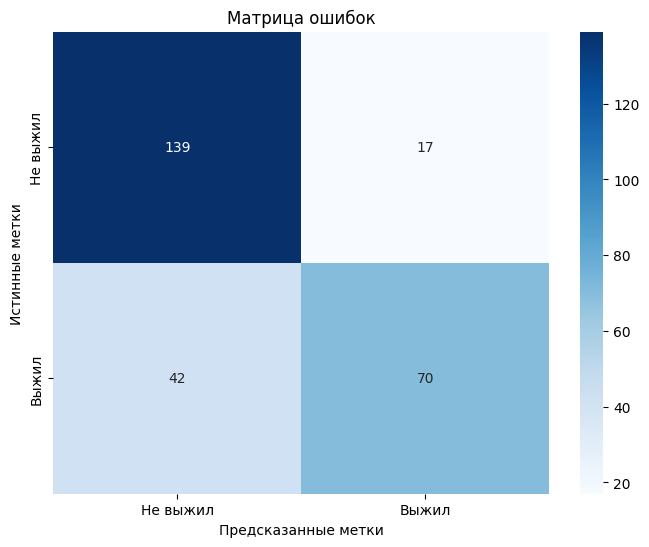

In [7]:
plot_conf_matrix(y_test, y_pred_catboost)

На матрице ошибок хорошо виден дисбаланс классов. Модель отдаёт предпочтению классу 0 - не вижил.

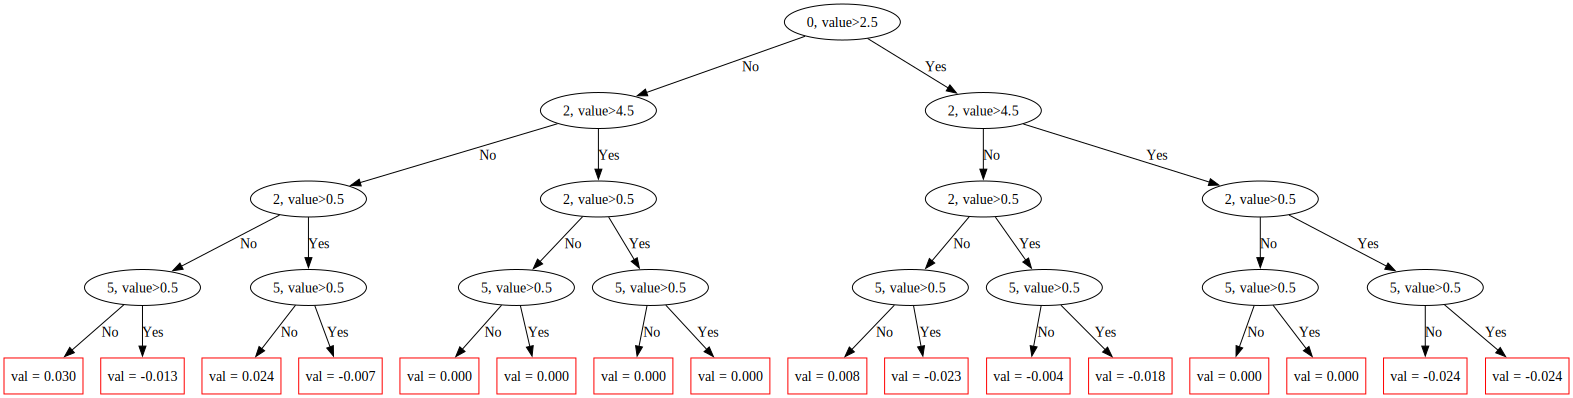

In [27]:
best_cat_model.plot_tree(
    tree_idx=0,
)

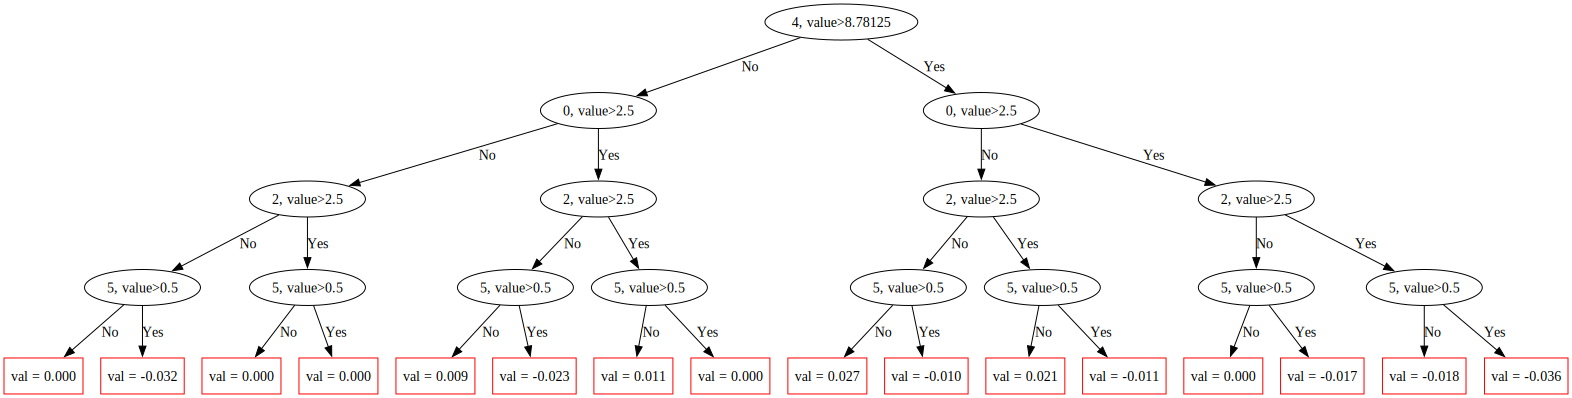

In [28]:
best_cat_model.plot_tree(
    tree_idx=1,
)

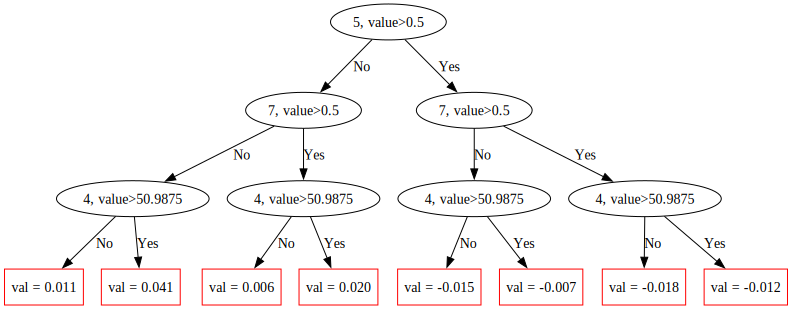

In [29]:
best_cat_model.plot_tree(
    tree_idx=2,
)

Судя по первым трём деревьям можно сказать, что наиболее важными являются признаки Пол, класс каюты, возраст, цена билета

Text(0.5, 1.0, 'Важность признаков CatBoost')

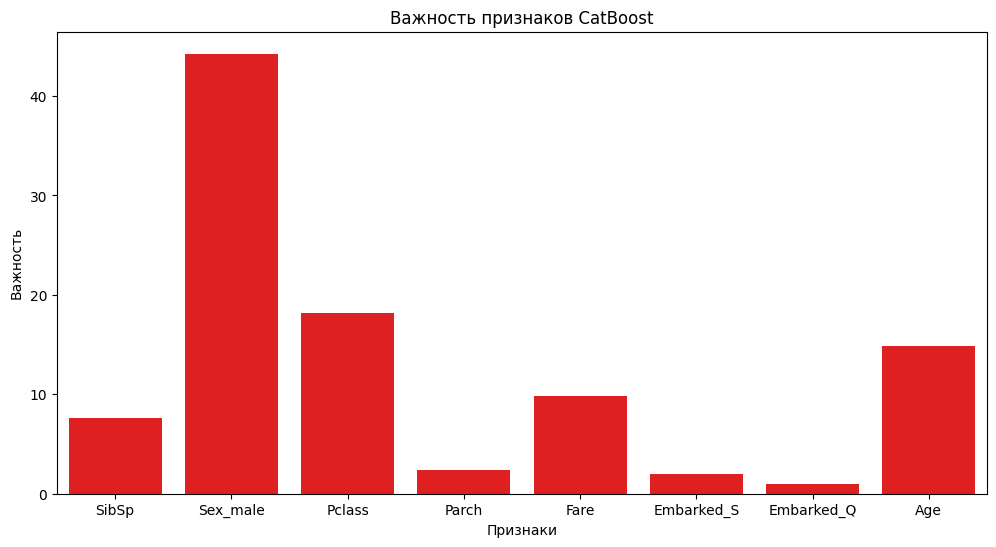

In [ ]:
cat_feature_importance = best_cat_model.get_feature_importance()
cat_feature_importance_df = pd.DataFrame({'Признаки': X.columns, 'Важность': cat_feature_importance})
cat_feature_importance_df.sort_values(by='Признаки', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Признаки', y='Важность', data=cat_feature_importance_df.head(10), color='red')
plt.title('Важность признаков CatBoost')

На гистограмме видно, что наиболее важные признаки для этой модели - пол, класс каюты, возраст, цена билета

# XGBoost

In [8]:
xgb_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
}

xgb_model = XGBClassifier(eval_metric="logloss")
grid_xgb = GridSearchCV(xgb_model, xgb_grid, cv=3, scoring='f1')
grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_

y_train_xgb = best_xgb_model.predict(X_train)
y_pred_xgb = best_xgb_model.predict(X_test)
print_metriks(y_train, y_train_xgb, "Метрики xgb на обучающей выборке")
print_metriks(y_test, y_pred_xgb, "Метрики xgb на тестовой выборке")

Метрики xgb на обучающей выборке
Accuracy: 0.872
Precision: 0.875
Recall: 0.761
F1: 0.814

Метрики xgb на тестовой выборке
Accuracy: 0.776
Precision: 0.810
Recall: 0.607
F1: 0.694



Модель xgb так же немного переобучилавсь, значения метрик у неё получились немного хуже, чем у catboost.

Матрица ошибок:
[[140  16]
 [ 44  68]]


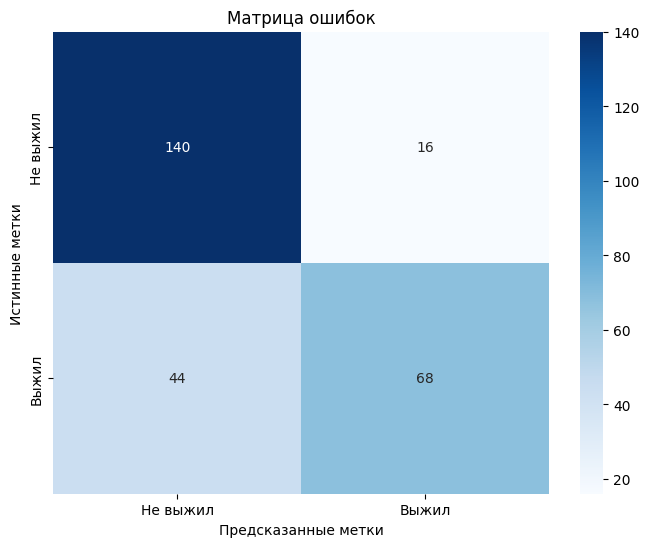

In [9]:
plot_conf_matrix(y_test, y_pred_xgb)

По матрице ошибок видно, что различия между предсказаниями catboost и xgb невелики

<Figure size 3000x2000 with 0 Axes>

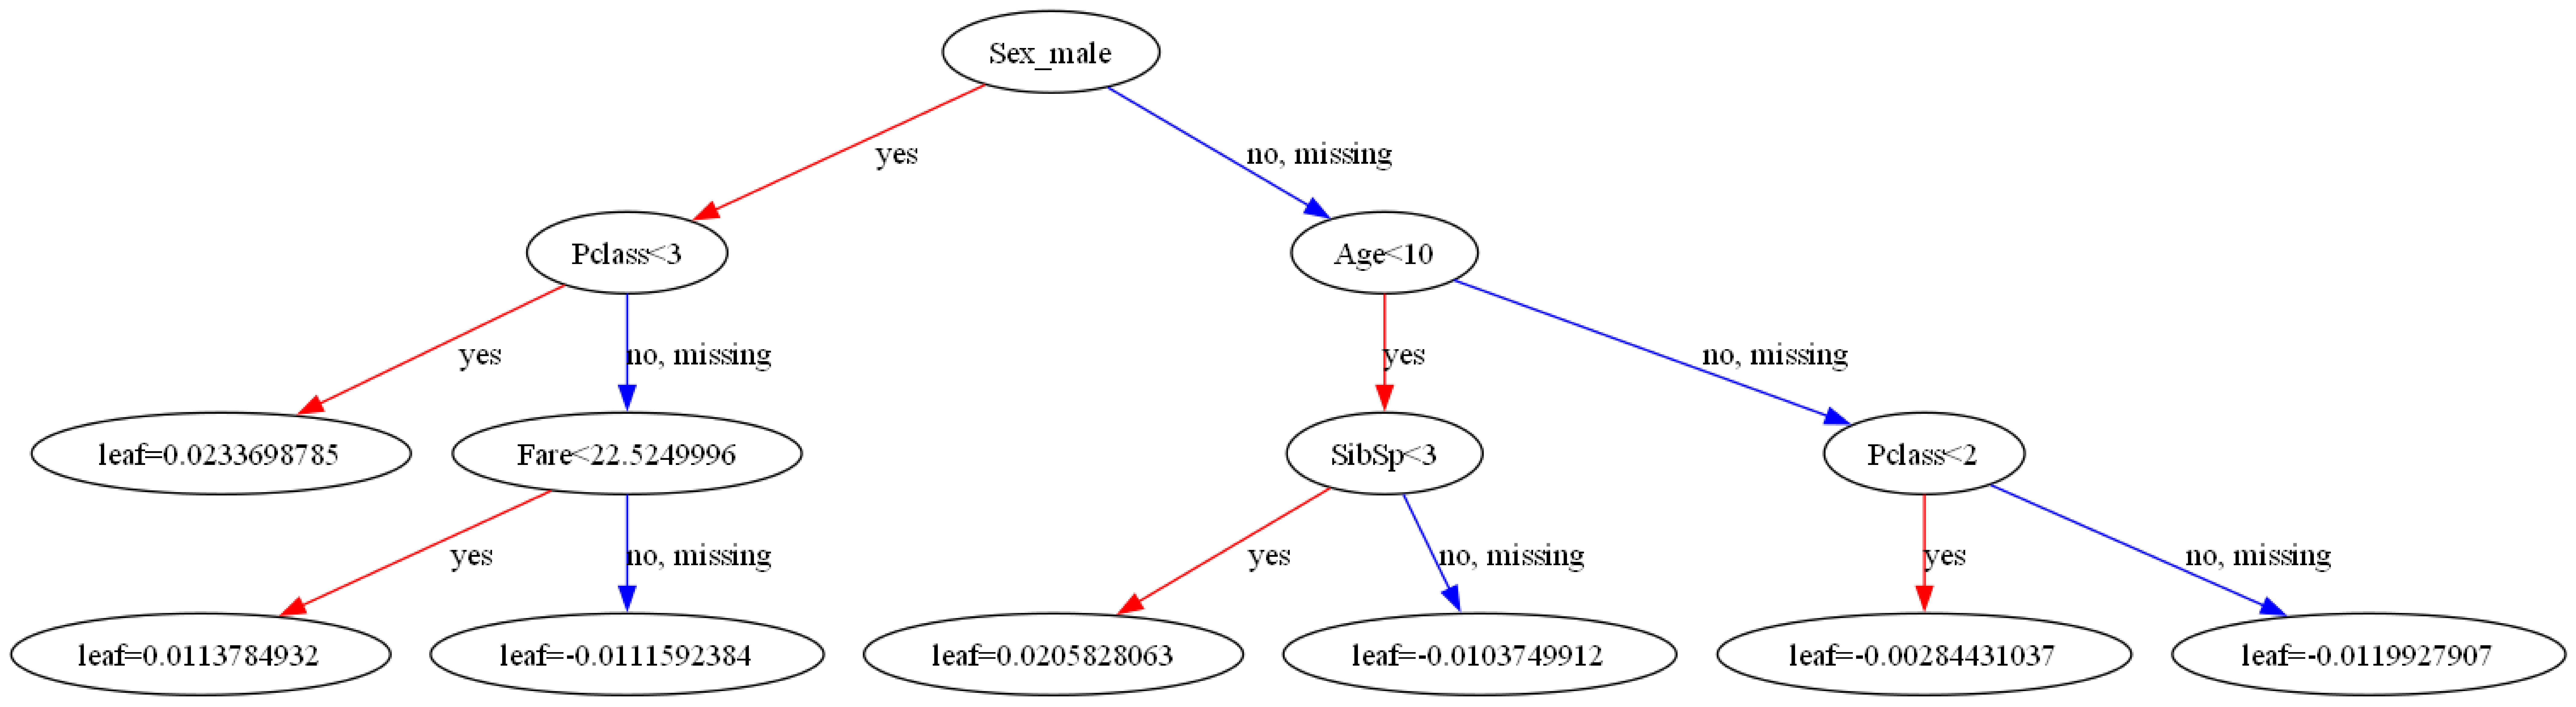

In [44]:
plt.figure(figsize=(30, 20))
xgboost_plot_tree(best_xgb_model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)

<Figure size 3000x2000 with 0 Axes>

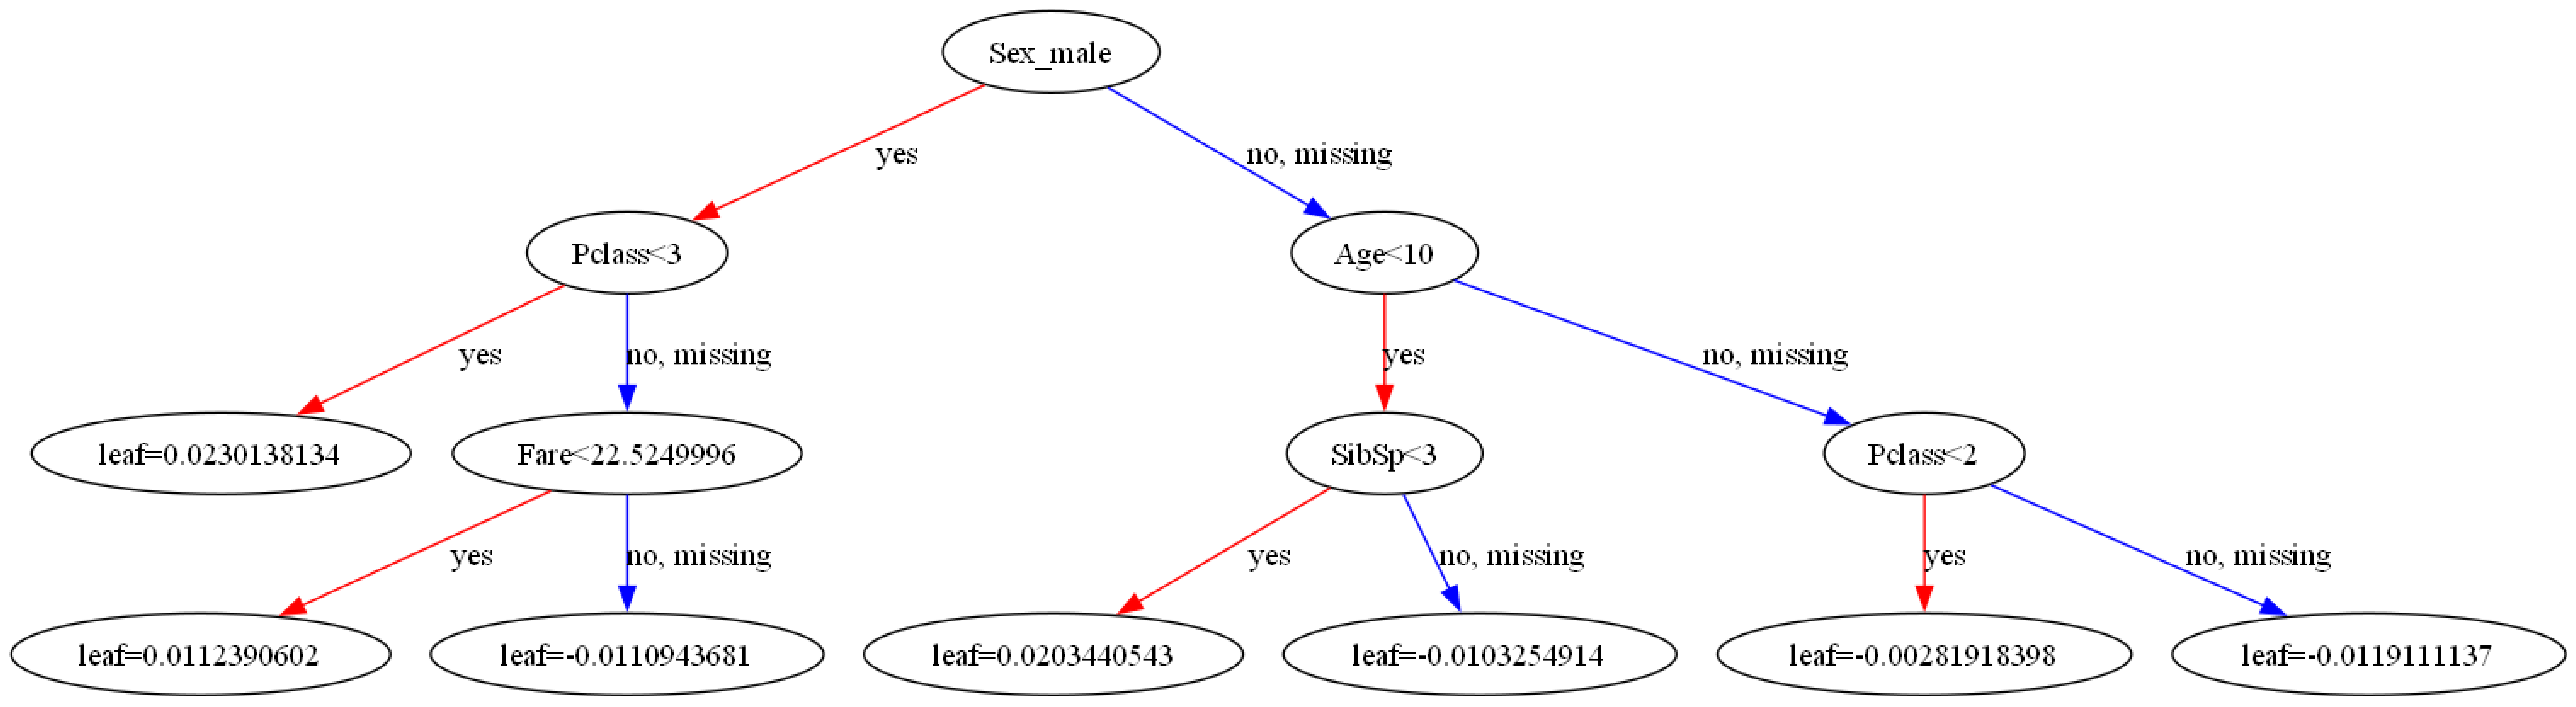

In [45]:
plt.figure(figsize=(30, 20))
xgboost_plot_tree(best_xgb_model, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(150, 100)

<Figure size 3000x2000 with 0 Axes>

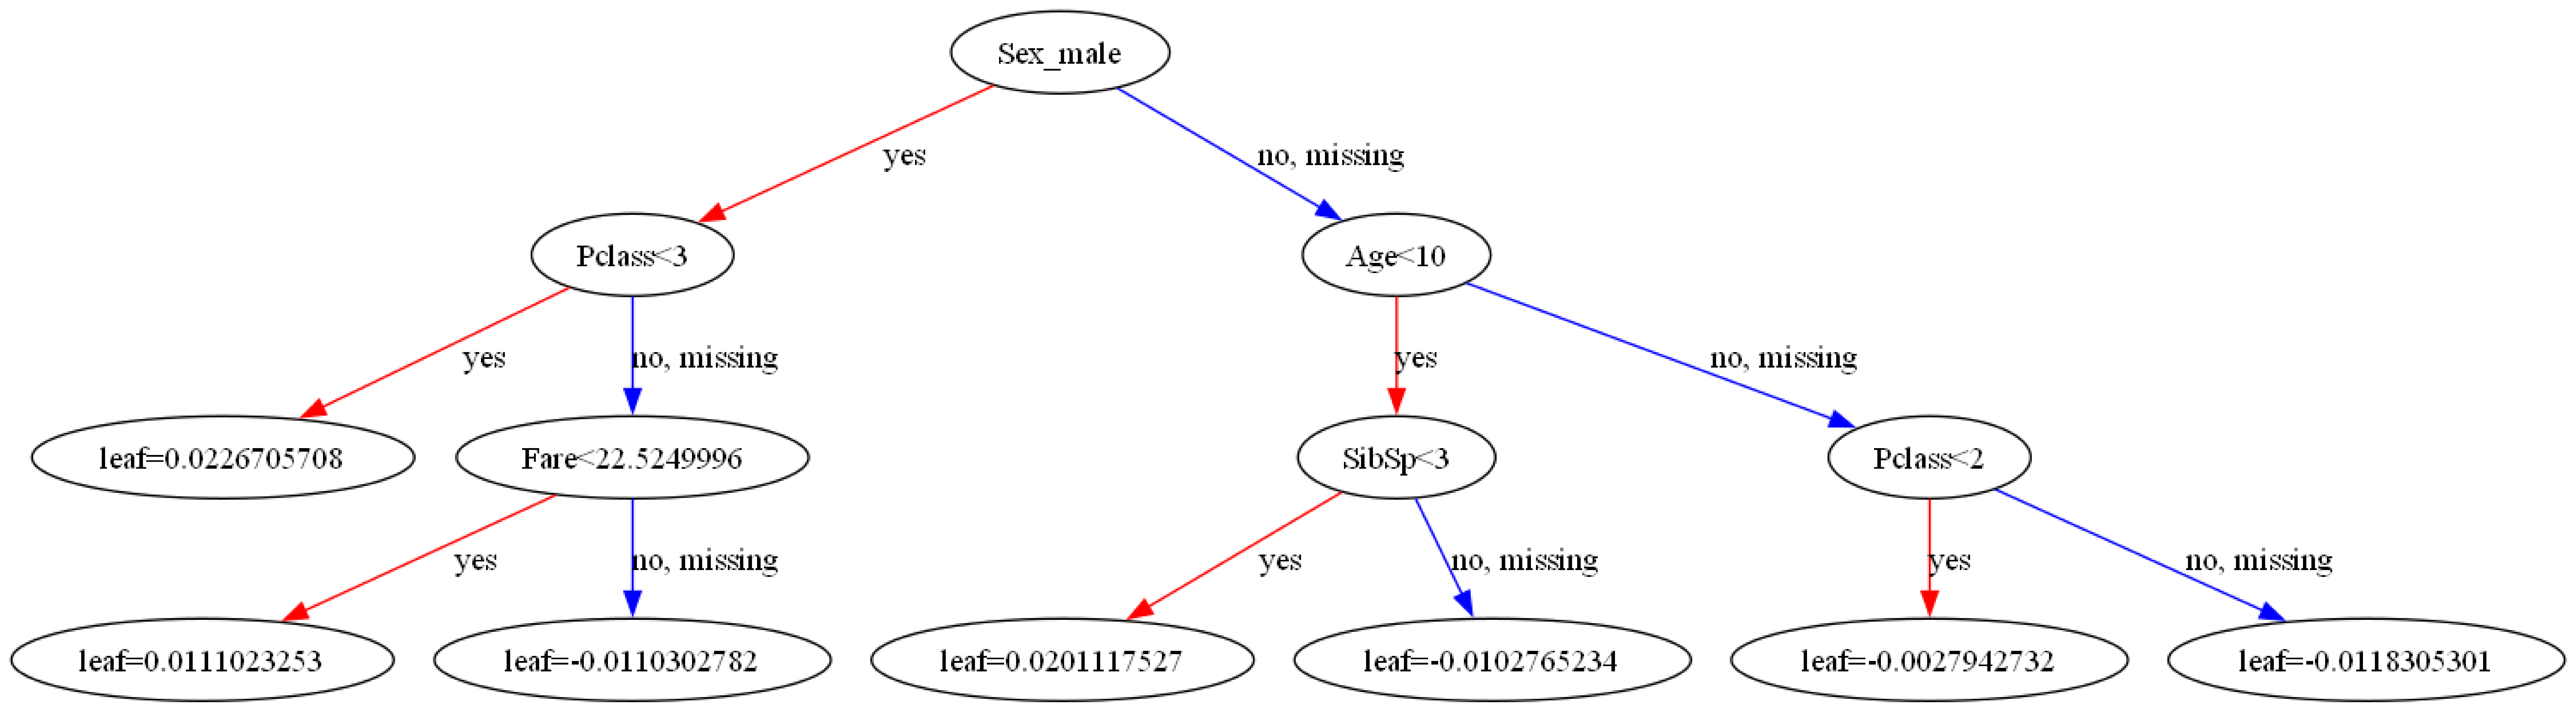

In [46]:
plt.figure(figsize=(30, 20))
xgboost_plot_tree(best_xgb_model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)

Судя по первым трём деревьям можно сказать, что наиболее важными являются признаки пол, возраст, класс каюты

Text(0.5, 1.0, 'Важность признаков XGBoost')

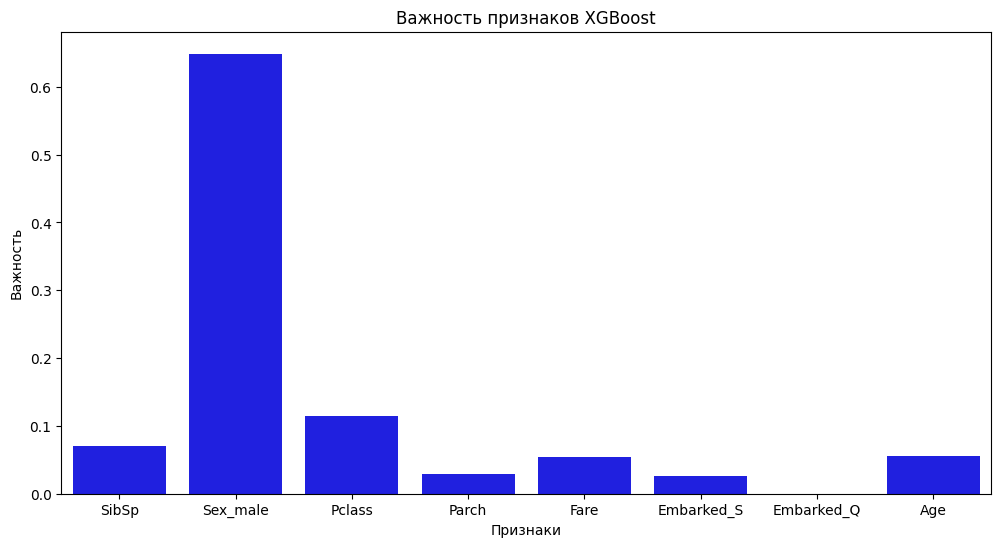

In [65]:
xgb_feature_importance = best_xgb_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Признаки': X.columns, 'Важность': xgb_feature_importance})
xgb_feature_importance_df.sort_values(by='Признаки', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Признаки', y='Важность', data=xgb_feature_importance_df.head(10), color='blue')
plt.title('Важность признаков XGBoost')

В этой модели наиболее важным признаком является пол, далее с большим отрывом возраст и класс каюты

# LightGBM

In [10]:
lgb_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
}

lgb_model = LGBMClassifier(force_row_wise=True)
grid_lgb = GridSearchCV(lgb_model, lgb_grid, cv=3, scoring='f1')
grid_lgb.fit(X_train, y_train)
best_lgb_model = grid_lgb.best_estimator_

[LightGBM] [Info] Number of positive: 153, number of negative: 262
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 415, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368675 -> initscore=-0.537907
[LightGBM] [Info] Start training from score -0.537907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [11]:
y_train_lgb = best_lgb_model.predict(X_train)
y_pred_lgb = best_lgb_model.predict(X_test)
print_metriks(y_train, y_train_lgb, "Метрики xgb на обучающей выборке")
print_metriks(y_test, y_pred_lgb, "Метрики xgb на тестовой выборке")

Метрики xgb на обучающей выборке
Accuracy: 0.864
Precision: 0.868
Recall: 0.743
F1: 0.801

Метрики xgb на тестовой выборке
Accuracy: 0.780
Precision: 0.827
Recall: 0.598
F1: 0.694



Матрица ошибок:
[[142  14]
 [ 45  67]]


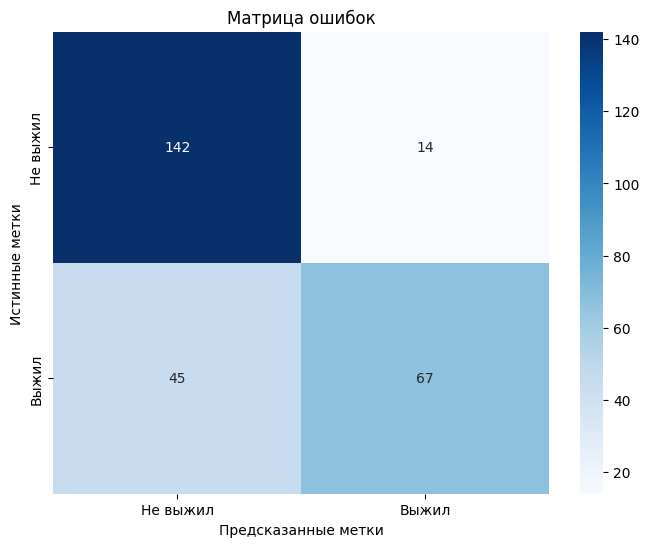

In [12]:
plot_conf_matrix(y_test, y_pred_lgb)

LightGBM получилась примерно такая же как XGBoost. Судя по метрикам и матрице ошибок разница очень невелика. 

In [52]:
plt.figure(figsize=(30, 20))
lightgbm_plot_tree(best_lgb_model, tree_index=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)

<Figure size 3000x2000 with 0 Axes>

In [53]:
plt.figure(figsize=(30, 20))
lightgbm_plot_tree(best_lgb_model, tree_index=1)
fig = plt.gcf()
fig.set_size_inches(150, 100)

<Figure size 3000x2000 with 0 Axes>

In [54]:
plt.figure(figsize=(30, 20))
lightgbm_plot_tree(best_lgb_model, tree_index=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)

<Figure size 3000x2000 with 0 Axes>

Судя по первым трём деревьям можно сказать, что наиболее важными являются признаки пол, возраст, класс каюты, цена билета

Text(0.5, 1.0, 'Важность признаков LightGBM')

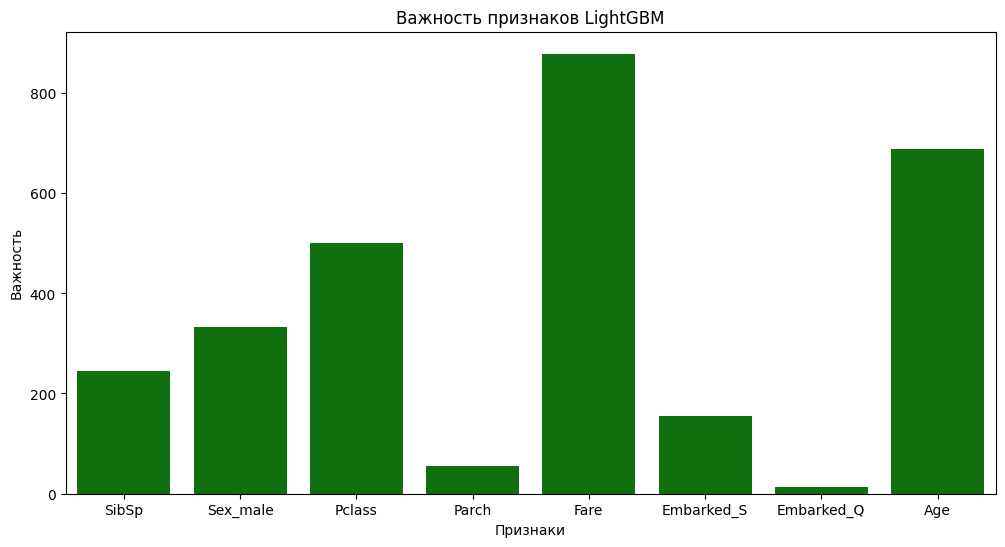

In [66]:


lgb_feature_importance = best_lgb_model.feature_importances_
lgb_feature_importance_df = pd.DataFrame({'Признаки': X.columns, 'Важность': lgb_feature_importance})
lgb_feature_importance_df.sort_values(by='Признаки', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Признаки', y='Важность', data=lgb_feature_importance_df.head(10), color='green')
plt.title('Важность признаков LightGBM')

А вот если посмотреть на гистограмму, то хорошо видно, что всё-таки наиболее важные признаки для этой модели - в первую очередь цена билета и возраст. Затем идут класс каюты и пол.

Сравнивая метрики трёх моделей - на первом месте CatBoost. Далее на втором месте XGBoost и LightGBM - метрики у них почти одинаковые